# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

In [22]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


Here is a sanity check to verify the implementation of SimpleNN.
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [24]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN
dummy_input = torch.randn(1, 3, 32, 32)
model = SimpleNN()
output = model(dummy_input)


expected_output_shape = (1, 10)
if output.shape == expected_output_shape:
    print("Output shape check passed!")
else:
    print("Output shape check failed.")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_parameters = count_parameters(model)

expected_parameters = (3 * 8 * 5 * 5 + 8) + (8 * 16 * 3 * 3 + 16) + (16 * 6 * 6 * 120 + 120) + (120 * 84 + 84) + (84 * 10 + 10)

if total_parameters == expected_parameters:
    print("Parameter count check passed!")
else:
    print("Parameter count check failed.")

#############################################

Output shape check passed!
Parameter count check passed!


## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (a)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint:
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [25]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
# specify preprocessing function

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
#############################################

When the data features are on different scales it becomes difficult to get to the optimal solution. We use normalisation to bring all the features to a similar scale for easier training. Normalisation is done by subtracting the mean from each feature  which ensures that the data is around zero, this removes any bias that might be there, dividing by the standard deviation scales the data and ensures that the data has a unit variance.

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import sys
sys.path.append('/content/drive/MyDrive/ECE661_HW2/tools')

In [26]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=torch.triu_indices,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [10]:
!nvidia-smi

Tue Oct  3 21:53:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
# specify the device for computation
#############################################
# your code here
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

model = SimpleNN()
model.to(device)
print(model)


#############################################

Using GPU
SimpleNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [28]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion =nn.CrossEntropyLoss()

# Add optimizer
optimizer =optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps:

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


In [29]:
# some hyperparameters
# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR
train_accuracies = []
val_accuracies = []

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    model.train()


    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0
    val_loss = 0# track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
         inputs, targets = inputs.to(device), targets.to(device)

         # compute the output and loss
         output= model(inputs)
         loss= criterion(output,targets)

         # zero the gradient

         optimizer.zero_grad()
         # backpropagation
         loss.backward()


        # apply gradient and update the weights
         optimizer.step()


        # count the number of correctly predicted samples in the current batch
         _, predicted = output.max(1)
         total_examples += targets.size(0)
         correct_examples += predicted.eq(targets).sum().item()
         train_loss += loss.item()

        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    model.eval()


    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs, targets =inputs.to(device), targets.to(device)


            # compute the output and loss
            output=model(inputs)
            loss= criterion(output,targets)


            # count the number of correctly predicted samples in the current batch
            _, predicted = output.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            val_loss += loss.item()

            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.9631, Training accuracy: 0.2812
Validation loss: 1.5845, Validation accuracy: 0.4196

Epoch 1:
Training loss: 1.4513, Training accuracy: 0.4731
Validation loss: 1.3587, Validation accuracy: 0.5146

Epoch 2:
Training loss: 1.2393, Training accuracy: 0.5565
Validation loss: 1.2008, Validation accuracy: 0.5746

Epoch 3:
Training loss: 1.1140, Training accuracy: 0.6026
Validation loss: 1.1132, Validation accuracy: 0.6020

Epoch 4:
Training loss: 1.0240, Training accuracy: 0.6387
Validation loss: 1.0805, Validation accuracy: 0.6224

Epoch 5:
Training loss: 0.9445, Training accuracy: 0.6684
Validation loss: 1.0268, Validation accuracy: 0.6418

Epoch 6:
Training loss: 0.8842, Training accuracy: 0.6882
Validation loss: 0.9975, Validation accuracy: 0.6546

Epoch 7:
Training loss: 0.8281, Training accuracy: 0.7066
Validation loss: 1.0208, Validation accuracy: 0.6512

Epoch 8:
Training loss: 0.7708, Training accuracy: 0.7271
Validation loss: 1.0522, 

## Comparing the Training and Validation Accuracies

In [32]:
import matplotlib.pyplot as plt
import numpy as np

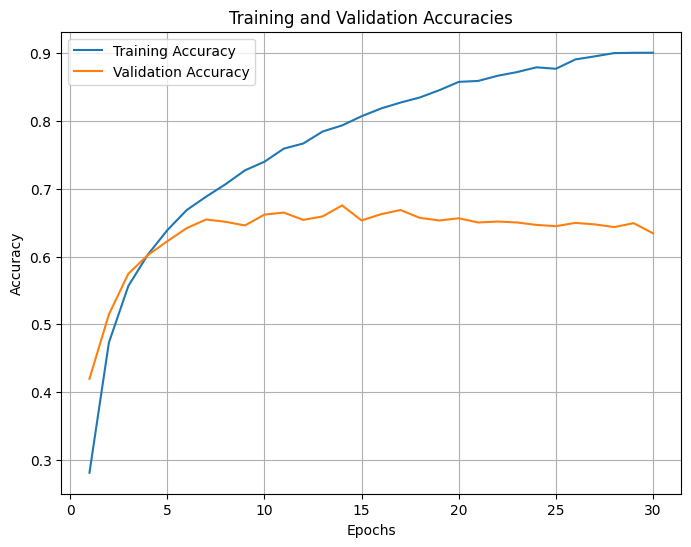

In [36]:
epochs = np.arange(1, EPOCHS + 1)


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

## Calculating the initial loss

In [43]:
model1 = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(model1.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
model1.train()

batch_idx, (inputs, targets) = next(enumerate(train_loader))
inputs, targets = inputs.to(device), targets.to(device)

output = model1(inputs)
loss = criterion(output, targets)

print(f"Initial Loss for First Batch: {loss.item():.4f}")

Initial Loss for First Batch: 2.2998


# Bonus: with learning rate decay

The following code can help you adjust the learning rate during training. You need to figure out how to incorporate this code into your training loop.
```python
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
```